In [1]:
import itertools
import json
import pathlib
from types import SimpleNamespace

from lib.test import coherent_test, test_model
from lib.config import modalities_list, data_dir
from lib.get_models import get_diffusion_model
from lib.diffusion_models import GaussianDiffusion

from lib.read_data import read_data
import argparse

import numpy as np
import pandas as pd
import torch

In [2]:
# input data
modalities_map = read_data(
    modalities=modalities_list,
    splits=['test'],
    data_dir=data_dir,
    dim=32,
)

Index of rnaseq test matches with cna test
Index of rppa test matches with cna test
Index of wsi test matches with cna test


In [3]:
datatype = 'wsi'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dim = 32

folder = "results"

metric = 'mse'

test_repeats = 2

In [4]:


print(f'Test the models to generate {datatype} with Coherent')

x_test = modalities_map[datatype]['test']

cond_datatypes = list(modalities_map.keys())
cond_datatypes.remove(datatype)


for r in range(2, len(cond_datatypes) + 1): #For each subset‐size r = 2…|cond_datatypes|
    for cond_combo in itertools.combinations(cond_datatypes, r):
        combo_name = "_".join(cond_combo)
        print(f'Generating {datatype} from {combo_name}')

        cond_test_list = [modalities_map[c]['test'] for c in cond_combo]
        
        models_list = []    

        weights_list = [] 

        diffusion = GaussianDiffusion(num_timesteps=1000).to(device)

        for c in cond_combo:
            # Path to “datatype_from_c/train/best_by_{metric}.pth”
            single_ckpt_dir = pathlib.Path(f'../{folder}/{dim}/{datatype}_from_{c}/train')
            ckpt_path = single_ckpt_dir / f'best_by_{metric}.pth'
            if not ckpt_path.exists():
                raise FileNotFoundError(f'Checkpoint not found: {ckpt_path}')

            # Load the checkpoint dict
            ckpt       = torch.load(ckpt_path, map_location='cpu')
            raw_cfg    = ckpt['config']
            config_c   = SimpleNamespace(**raw_cfg)
            state_dict = ckpt[f'best_model_{metric}']
            
            best_loss = ckpt['best_loss']
            weights_list.append(best_loss)


            x_dim = x_test.shape[1]
            cond_dim = modalities_map[c]['test'].shape[1]
            
            model_c = get_diffusion_model(
                config_c.architecture,
                diffusion,
                config_c,
                x_dim=x_dim,
                cond_dims=cond_dim
            )
            model_c.load_state_dict(state_dict)
            model_c.to(device).eval()

            models_list.append(model_c)






Test the models to generate wsi with Coherent
Generating wsi from cna_rnaseq
Generating wsi from cna_rppa
Generating wsi from rnaseq_rppa
Generating wsi from cna_rnaseq_rppa


In [5]:
from lib.test import coherent_test_cos_rejection

In [6]:
# Run coherent sampling
metrics_summary, generated_df, cos_stats = coherent_test_cos_rejection(
    x_test, cond_test_list, models_list, diffusion,
    max_retries=10, test_iterations = 2, device=device, weights_list=weights_list
)


In [7]:
metrics_summary

{'mse_mean': 0.5600419342517853,
 'mse_std': 7.05420970916748e-05,
 'r2_mean': 0.43839775025844574,
 'r2_std': 0.0003247112035751343,
 'cos_mean': 0.32462699711322784,
 'cos_std': 9.600818157196045e-05}

In [8]:
cos_stats['trajectories']

[array([[0.01331145, 0.0147872 , 0.0137794 , ..., 1.2950647 , 1.272511  ,
         1.276718  ],
        [0.00834453, 0.00798154, 0.00833595, ..., 1.1951866 , 1.1722248 ,
         1.1733754 ],
        [0.00681782, 0.00651461, 0.00616348, ..., 1.2703575 , 1.2478721 ,
         1.2314368 ],
        ...,
        [0.01124507, 0.01099598, 0.01134193, ..., 1.2370138 , 1.2273118 ,
         1.1994525 ],
        [0.0082854 , 0.00945961, 0.01004362, ..., 1.2540528 , 1.2595387 ,
         1.25502   ],
        [0.00768137, 0.00674438, 0.00676262, ..., 1.1429546 , 1.1414871 ,
         1.154631  ]], dtype=float32),
 array([[0.00769949, 0.00728756, 0.00836021, ..., 1.3006717 , 1.3021617 ,
         1.3201649 ],
        [0.00881237, 0.00827241, 0.00741947, ..., 1.2391489 , 1.2473011 ,
         1.3067505 ],
        [0.00736225, 0.007649  , 0.00714147, ..., 1.3265585 , 1.3118643 ,
         1.2895997 ],
        ...,
        [0.01018965, 0.00928509, 0.01012802, ..., 1.2235335 , 1.236914  ,
         1.2300159 

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the lists from cos_stats
trajectories = cos_stats['trajectories']  # list of (num_samples, T) arrays
fracs        = cos_stats['fracs']         # list of (num_samples,) arrays
retries      = cos_stats['retries']       # list of (num_samples,) arrays



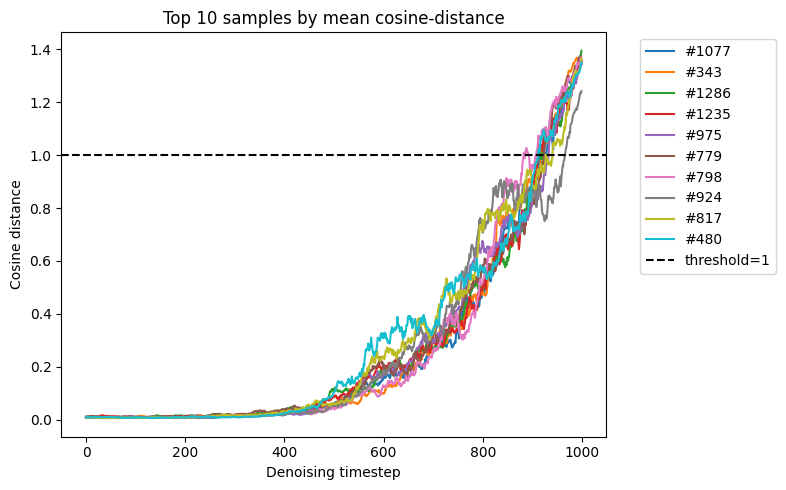

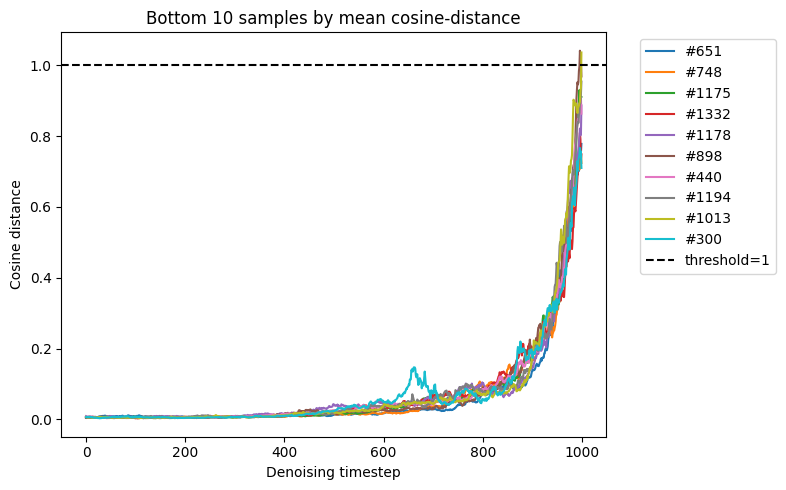

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Choose which iteration of cos_stats to visualize
iter_idx = 0

cos_threshold = 1

# Extract
traj = trajectories[iter_idx]  # shape: (num_samples, T)
# Compute per‐sample mean over timesteps
mean_vals = np.mean(traj, axis=1)  # → (num_samples,)

# Sort sample indices by their mean trajectory value
sorted_idx = np.argsort(mean_vals)

# Pick bottom 10 and top 10
lowest_idxs  = sorted_idx[:10]
highest_idxs = sorted_idx[-10:]

# X‐axis: timesteps
T = traj.shape[1]
timesteps = np.arange(T)

# Plot the 10 highest‐mean trajectories
plt.figure(figsize=(8, 5))
for idx in highest_idxs:
    plt.plot(timesteps, traj[idx], label=f"#{idx}")
plt.axhline(cos_threshold, color='k', linestyle='--', label=f"threshold={cos_threshold}")
plt.title("Top 10 samples by mean cosine‐distance")
plt.xlabel("Denoising timestep")
plt.ylabel("Cosine distance")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot the 10 lowest‐mean trajectories
plt.figure(figsize=(8, 5))
for idx in lowest_idxs:
    plt.plot(timesteps, traj[idx], label=f"#{idx}")
plt.axhline(cos_threshold, color='k', linestyle='--', label=f"threshold={cos_threshold}")
plt.title("Bottom 10 samples by mean cosine‐distance")
plt.xlabel("Denoising timestep")
plt.ylabel("Cosine distance")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


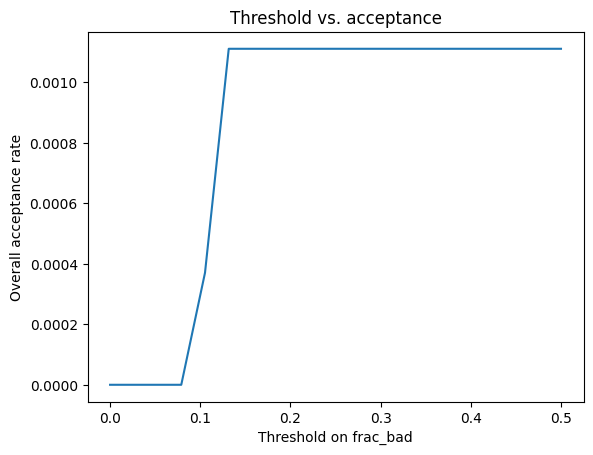

In [ ]:
thresholds = np.linspace(0, 0.5, 20)
mean_accept_rates = []
for thr in thresholds:
    accept_rate = (all_fracs <= thr).mean()
    mean_accept_rates.append(accept_rate)

plt.plot(thresholds, mean_accept_rates)
plt.xlabel("Threshold on frac_bad")
plt.ylabel("Overall acceptance rate")
plt.title("Threshold vs. acceptance")
plt.show()


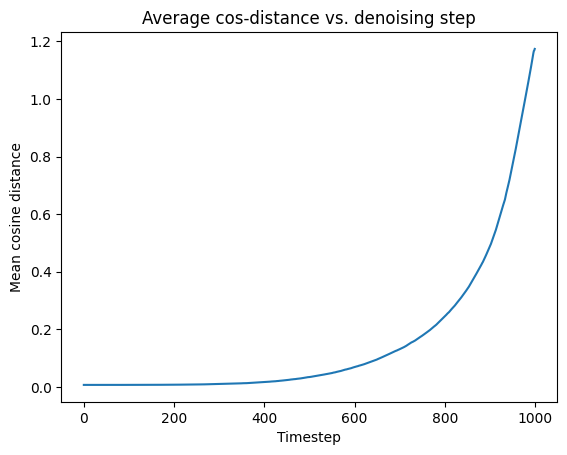

In [ ]:
# Average across samples & iterations, for each timestep
all_trajs = np.concatenate(trajectories, axis=0)  # ((it×samples), T)
mean_over_time = all_trajs.mean(axis=0)

plt.plot(np.arange(T), mean_over_time)
plt.xlabel("Timestep")
plt.ylabel("Mean cosine distance")
plt.title("Average cos‐distance vs. denoising step")
plt.show()


In [ ]:
mean_frac0

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)